# Keras Transformer Formality Transfer Model

References:
- https://keras.io/examples/nlp/neural_machine_translation_with_transformer/


In [1]:
from keras.layers import Embedding, Layer, MultiHeadAttention, Dense, LayerNormalization, Lambda, Dropout, Softmax, TextVectorization
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Model, Sequential
from keras import Input
import tensorflow as tf


%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import string
import time
import re
import os

## Load Training Data


In [2]:
num_samples = None
vocab_size = 15000

with open("labelled.txt", "r") as l:
    raw_data = l.read()
lines = [x.strip() for x in raw_data.split("\n")]
max_length = max(len(i) for i in lines)

X = []
Y = []
for i in range(0, len(lines)-1 if num_samples is None else min(len(lines)-1,num_samples*2), 2):
    X.append(lines[i])
    Y.append(f"[start] {lines[i+1]} [end]")

train_prop = 0.9
train_num = int(train_prop * len(X))

X_train, X_test = X[:train_num], X[train_num:]
Y_train, Y_test = Y[:train_num], Y[train_num:]

## Vectorize training data

In [3]:
strip_chars = string.punctuation.replace("[", "").replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")


X_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=max_length,
)
X_vectorization.adapt(X_train)

Y_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=max_length + 1,
    standardize=custom_standardization,
)
Y_vectorization.adapt(Y_train)

def format_dataset(X, Y):
    X = X_vectorization(X)
    Y = Y_vectorization(Y)
    return (
        {"encoder_inputs": X, "decoder_inputs": Y[:, :-1]},
        Y[:, 1:]
    )

def make_dataset(X, Y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y)).batch(batch_size)
    return dataset.map(format_dataset).shuffle(2048).prefetch(16).cache()

## Encoder


In [4]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential(
            [Dense(dense_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        padding_mask = None
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

## Positional Embedding

In [5]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

## Decoder

In [6]:
class TransformerDecoder(Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential(
            [Dense(latent_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.layernorm_3 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        padding_mask = None
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


## Define Model

In [7]:
embedding_dim = 256
latent_dim = 2048
num_heads = 8

checkpoints_dir = os.path.abspath("transformer-checkpoints")

encoder_inputs = Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(max_length, vocab_size, embedding_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embedding_dim, latent_dim, num_heads)(x)
encoder = Model(encoder_inputs, encoder_outputs)

decoder_inputs = Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = Input(shape=(None, embedding_dim), name="decoder_state_inputs")
x = PositionalEmbedding(max_length, vocab_size, embedding_dim)(decoder_inputs)
x = TransformerDecoder(embedding_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = Dropout(0.5)(x)
decoder_outputs = Dense(vocab_size, activation="softmax")(x)
decoder = Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
model = Model(
    [encoder_inputs, decoder_inputs], decoder_outputs
)
model.summary()

model.compile(
    "rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3993600     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[0][0

## Configure Training Callbacks


In [8]:
class Plotter(Callback):
    id_counter = 0

    def __init__(self):
        super().__init__()
        self.id = f"plot-{Plotter.id_counter}"
        Plotter.id_counter += 1
        self.fig, self.ax = plt.subplots(figsize=(24, 6), dpi=80)
        self.ax.set_xlabel("Epoch")
        self.ax.set_ylabel("Loss")
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10.0))
        self.ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=1.0))
        # self.ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
        # self.ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.02))
        self.ax.grid(which="major", color="#888888")
        self.ax.grid(which="minor", color="#bbbbbb")

        self.fig.patch.set_facecolor("white")
        box = self.ax.get_position()
        self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        display.display(self.fig, display_id=self.id)

        self.max_loss = -1

        self.epochs = []
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        for l in self.ax.lines:
            l.remove()
        
        self.epochs.append(epoch)
        self.train_losses.append(t_loss:=logs["loss"])
        self.val_losses.append(v_loss:=logs["val_loss"])

        self.max_loss = max(self.max_loss, t_loss, v_loss)
        
        t_line, = self.ax.plot(self.epochs, self.train_losses, c="#55CDFC")
        v_line, = self.ax.plot(self.epochs, self.val_losses, c="#F7A8B8")
        self.ax.autoscale()
        self.ax.set_ylim(0, self.max_loss * 1.1)
        self.ax.legend([t_line, v_line], ["Training", "Validation"], loc='center left', bbox_to_anchor=(1, 0.5))
        display.update_display(self.fig, display_id=self.id)

class PrintDemo(Callback):
    def __init__(self, demo_str):
        super().__init__()
        self.start_time = time.time()
        self.last_time = self.start_time
        self.demo_str = demo_str
    
    def format_time(self, seconds):
        if seconds < 60:
            return f"{seconds:.2f}s"
        elif seconds < 3600:
            return f"{(seconds/60):.2f}min"
        else:
            return f"{(seconds/3600):.2f}hr"

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            return
        now = time.time()
        elapsed = now-self.start_time
        pred_str = decode_sequence(self.demo_str)
        max_preview_length = 50
        preview = (pred_str[:max_preview_length] + '...') if len(pred_str) > max_preview_length else pred_str

        print(f"Time for Epoch: {self.format_time(now-self.last_time)}, Total Elapsed: {self.format_time(elapsed)}, Total ETA: {self.format_time(elapsed/epoch * (epochs-epoch))}")
        print(f"\"{demo_str}\" -> \"{preview}\"\n")
        self.last_time = now

## Delete Existing Checkpoints &mdash; WARNING


In [9]:
if not os.path.isdir(checkpoints_dir):
    os.makedirs(checkpoints_dir)

for f in os.listdir(checkpoints_dir):
    os.unlink(os.path.join(checkpoints_dir, f))

## Decoding function

In [10]:
Y_vocab = Y_vectorization.get_vocabulary()
Y_index_lookup = dict(zip(range(len(Y_vocab)), Y_vocab))
max_decoded_sentence_length = max_length

def decode_sequence(input_sentence):
    tokenized_input_sentence = X_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = Y_vectorization([decoded_sentence])[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = Y_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

## Train


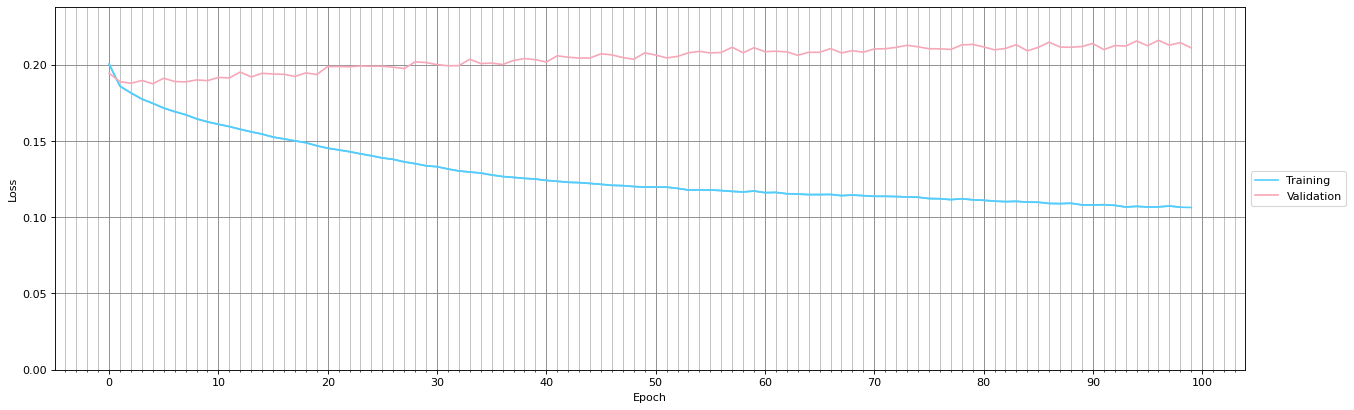

Epoch 1/100
113/113 [==============================] - 33s 258ms/step - loss: 0.2004 - accuracy: 0.1295 - val_loss: 0.1944 - val_accuracy: 0.1379
Time for Epoch: 33.04s, Total Elapsed: 33.04s, Total ETA: 54.52min
"You should seek advice from a medical professional." -> "[start] it is the is is is is a is is a is a is a ..."

Epoch 2/100
113/113 [==============================] - 30s 266ms/step - loss: 0.1859 - accuracy: 0.1716 - val_loss: 0.1888 - val_accuracy: 0.1891
Time for Epoch: 30.80s, Total Elapsed: 1.06min, Total ETA: 52.14min
"You should seek advice from a medical professional." -> "[start] the the the the the a a a a a a a a a a a ..."

Epoch 3/100
113/113 [==============================] - 30s 268ms/step - loss: 0.1814 - accuracy: 0.1944 - val_loss: 0.1878 - val_accuracy: 0.1888
Time for Epoch: 53.08s, Total Elapsed: 1.95min, Total ETA: 1.05hr
"You should seek advice from a medical professional." -> "[start] it is a a [end]"

Epoch 4/100
113/113 [============================

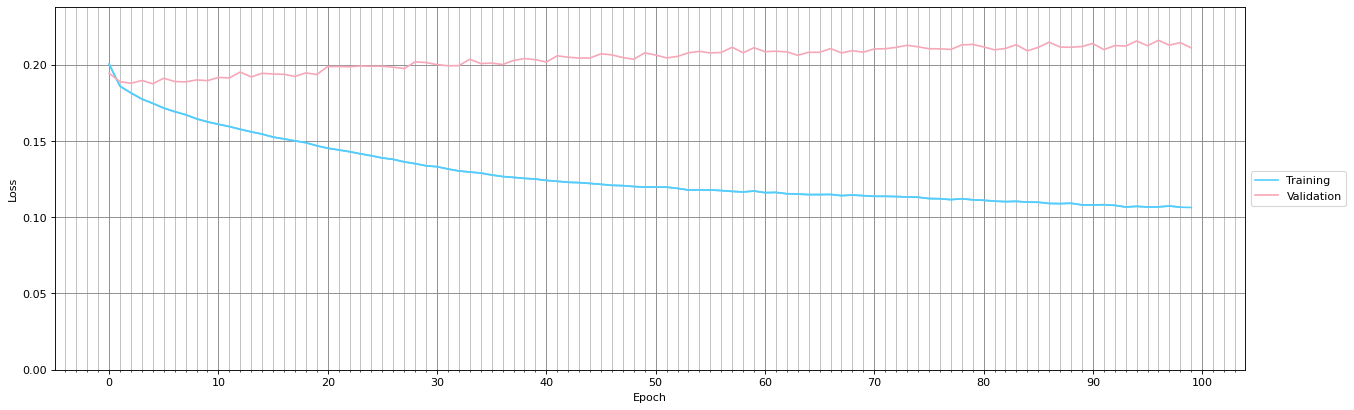

In [11]:
batch_size = 16
epochs = 100

train_data = make_dataset(X_train, Y_train, batch_size)
test_data = make_dataset(X_test, Y_test, batch_size)

demo_str = "You should seek advice from a medical professional."

filepath = os.path.join(checkpoints_dir, "transformer-f2c-{epoch:02d}-{loss:.4f}.ckpt")
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, monitor="loss", verbose=0, save_best_only=True, mode="min")

model.fit(
    train_data,
    epochs=epochs,
    validation_data=(test_data),
    callbacks=[Plotter(), checkpoint, PrintDemo(demo_str)]
)

    

## Load Checkpoint

In [ ]:
latest = tf.train.latest_checkpoint(checkpoints_dir)
model.load_weights(latest)

## Test

In [ ]:
test_str = "You should seek advice from a medical professional."

start = time.time()
pred_str = decode_sequence(test_str)
elapsed = time.time() - start

print(test_str)
print("->")
print(pred_str)
print(f"Took {elapsed:5f} seconds")